# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [266]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV

from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.metrics import f1_score

import pandas as pd


np.random.seed(50)

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [267]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [268]:
def P1(num_examples=5):
    for i in range (num_examples):
        print ("-" * 80)
        print ("This is an example of Group:", train_labels[i], \
               "type: ",newsgroups_train.target_names[train_labels[i]])
        print ("-" * 80)
        print (train_data[i])
        print ("-" * 80)
        print ("\n")
        
        #print (train_labels[i])
P1()

--------------------------------------------------------------------------------
This is an example of Group: 1 type:  comp.graphics
--------------------------------------------------------------------------------
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
This is an ex

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [269]:
def P2():
    vectorizer = CountVectorizer()
    feature_vec = vectorizer.fit_transform(train_data)
    
    print ("\n")
    #print (np.shape(feature_vec[1]))
    
    #Question a. 
    #Size of vocabulary
    print ("-"*80)
    print ("Question 2.a")
    print ("-"*80)
    
    print ("Shape of feature vector: ", np.shape(feature_vec))
    print ("Size of vocabulary: ", np.shape(feature_vec)[1])
    
    #Average size of non-zero feature values
    print ("Number of non-zero features in matrix: ", feature_vec.nnz)
    print ("Size of feature vector matrix: ", np.prod(np.shape(feature_vec)))
    print ("Fraction of non-zero entries in matrix: {0:0.5f}".format(feature_vec.nnz/(np.prod(np.shape(feature_vec)))))
    print ("Average size of non-zero feature values per document: {0:0.2f}"
           .format(feature_vec.nnz/(np.shape(feature_vec))[0]))
    print ("-"*80)
    print ("\n")
    
    #Question b
    print ("-"*80)
    print ("Question 2.b")
    print ("-"*80)
    
    #First and last feature names
    print ("First feature name:", vectorizer.get_feature_names()[0])
    print ("Last feature name:", vectorizer.get_feature_names()[len(vectorizer.get_feature_names()) - 1])
    print ("\n")
    
    #Question c
    print ("-"*80)
    print ("Question 2.c")
    print ("-"*80)
    
    #Specifying own vocabulary with [atheism", "graphics", "space", "religion"]
    my_vocab = ["atheism", "graphics", "space", "religion"]
    my_vectorizer = CountVectorizer(vocabulary=my_vocab)
    my_feature_vec = my_vectorizer.fit_transform(train_data)
    
    print ("Shape of my feature vector: ", np.shape(my_feature_vec))
    print ("Size of my vocabulary: ", np.shape(my_feature_vec)[1])
    
    #Average size of non-zero feature values
    print ("Number of non-zero features in matrix with my vocab: ", my_feature_vec.nnz)
    print ("Size of feature vector matrix with my vocab: ", np.prod(np.shape(my_feature_vec)))
    print ("Fraction of non-zero entries in matrix: {0:0.5f} with my vocab".format(my_feature_vec.nnz/(np.prod(np.shape(my_feature_vec)))))
    print ("Average size of non-zero feature values per document: {0:0.2f} with my vocab"
           .format(my_feature_vec.nnz/(np.shape(my_feature_vec))[0]))
    print ("-"*80)
    print ("\n")
    
    #Question d
    print ("-"*80)
    print ("Question 2.d")
    print ("-"*80)
    
    #Bi-gram vectorizer
    bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                        token_pattern=r'\b\w+\b', 
                                        min_df=1)
    bigram_feature_vec = bigram_vectorizer.fit_transform(train_data)
    print ("Size of bi-gram vocabulary: ", np.shape(bigram_feature_vec)[1])
    
    #Trigram vectorizer
    trigram_vectorizer = CountVectorizer(ngram_range=(1, 3),
                                        token_pattern=r'\b\w+\b', 
                                        min_df=1)
    trigram_feature_vec = trigram_vectorizer.fit_transform(train_data)
    print ("Size of tri-gram vocabulary: ", np.shape(trigram_feature_vec)[1])
    print ("\n")
    
    #Question e
    print ("-"*80)
    print ("Question 2.e")
    print ("-"*80)
    
    #Using mind_df of 10, build unigram vectorizer
    uni_min_df10_vectorizer = CountVectorizer(min_df = 10)
    uni_min_df10_feature_vec = uni_min_df10_vectorizer.fit_transform(train_data)
    print ("Size of unigram vocabulary with df = 10: ", np.shape(uni_min_df10_feature_vec)[1])
    print ("\n")
    
    #Question f
    print ("-"*80)
    print ("Question 2.f")
    print ("-"*80)
    
    #Get vocab for train data using original vectorizer one more time
    train_data_vectorizer = CountVectorizer()
    train_feature_vec = train_data_vectorizer.fit_transform(train_data)
    print ("Size of train data vocabulary: ", np.shape(train_feature_vec)[1])
    
    #Get vocab for dev data using original vectorizer
    dev_data_vectorizer = CountVectorizer()
    dev_feature_vec = dev_data_vectorizer.fit_transform(dev_data)
    print ("Size of dev data vocabulary: ", np.shape(dev_feature_vec)[1])
    
    #find out which keys are in dev data, but not in the training data
    #missing_key_cnt = 0
    #for key in dev_feature_vec : 
    #   if key not in train_feature_vec :
    #       missing_key_cnt += 1
   
    missing_keys = set(dev_data_vectorizer.vocabulary_.keys()) - set(train_data_vectorizer.vocabulary_.keys())
    missing_key_cnt = len(missing_keys)
    print ("Number of missing keys", missing_key_cnt)
            
    print ("Fraction of words from dev data missing in train data vocabulary: {0:.2f}"
           .format(missing_key_cnt/np.shape(dev_feature_vec)[1]))
    print ("\n")

    
    
P2()



--------------------------------------------------------------------------------
Question 2.a
--------------------------------------------------------------------------------
Shape of feature vector:  (2034, 26879)
Size of vocabulary:  26879
Number of non-zero features in matrix:  196700
Size of feature vector matrix:  54671886
Fraction of non-zero entries in matrix: 0.00360
Average size of non-zero feature values per document: 96.71
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Question 2.b
--------------------------------------------------------------------------------
First feature name: 00
Last feature name: zyxel


--------------------------------------------------------------------------------
Question 2.c
--------------------------------------------------------------------------------
Shape of my feature vector:  (2034, 4)
Size of my vocabulary:  4
Number of no

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [270]:
def P3():
    
    #Unigram CountVectorizer
    vec = CountVectorizer()
    
    #create training vector
    X_train = vec.fit_transform(train_data)
    Y_train = train_labels
    
    #print shapes
    print ("Shape of training data", np.shape(X_train))
    print ("Shape of training labels", np.shape(Y_train))
    
    #Now let's try out different algorithms with this training set
    #kNN - find optimal value of k using GridSearch
    k_list = [2*k+3 for k in range (25)]
    k_values = {'n_neighbors' : k_list}
    model_knn = KNeighborsClassifier()
    clf_knn = GridSearchCV(model_knn, k_values, cv = 5)
    clf_knn.fit(X_train, Y_train)
    print ("-"*80)
    print ("Trying out Grid Search on k values for KNN Algorithm")
    print ("")
    print(clf_knn.cv_results_['mean_test_score'])
    print("The best k value for KNN:", clf_knn.best_params_)
    print("The best f1 score for KNN", clf_knn.best_score_)
    print ("-"*80)
    print ("\n")

    #Now Multinomial NB
    model_nb = MultinomialNB()
    alpha_values = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]}
    clf_nb = GridSearchCV(model_nb, alpha_values, cv =5)
    clf_nb.fit(X_train, Y_train)
    print ("-"*80)
    print ("Trying out Grid Search on alpha values for Multinomial Naive Bayes Algorithm")
    print(clf_nb.cv_results_['mean_test_score'])
    print("The best alpha value for Multinomial NB", clf_nb.best_params_)
    print("The best f1 score for Multinomial NB", clf_nb.best_score_)
    print ("-"*80)
    print ("\n")
    
    #Logistic Regression
    model_lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500, tol=0.01)
    C_values = {'C': [0.001, 0.01, 0.1, 1, 10, 100,1000]}
    clf_lr = GridSearchCV(model_lr, C_values, cv =5)
    clf_lr.fit(X_train, Y_train)
    print ("-"*80)
    print ("Trying out Grid Search on C values for Logistic Regression")
    print(clf_lr.cv_results_['mean_test_score'])
    print("The best alpha value for Logistic Regression", clf_lr.best_params_)
    print("The best f1 score for Logistic Regression",clf_lr.best_score_)
    print ("-"*80)
    print ("\n")    
    
P3()

Shape of training data (2034, 26879)
Shape of training labels (2034,)
--------------------------------------------------------------------------------
Trying out Grid Search on k values for KNN Algorithm

[0.40363815 0.41494592 0.43608653 0.42822026 0.4346116  0.43952802
 0.43215339 0.42772861 0.44346116 0.44001967 0.42969518 0.43854474
 0.43510324 0.43313668 0.43608653 0.4252704  0.42428712 0.42084562
 0.42625369 0.42281219 0.43117011 0.42576205 0.42772861 0.43166175
 0.43756146]
The best k value for KNN: {'n_neighbors': 19}
The best f1 score for KNN 0.44346116027531957
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Trying out Grid Search on alpha values for Multinomial Naive Bayes Algorithm
[0.82497542 0.8259587  0.82546706 0.82841691 0.82055064 0.79990167
 0.71435595]
The best alpha value for Multinomial NB {'alpha': 0.01}
The best f1 score for Multinomial NB 0.828416

P 3a. Why doesn't nearest neighbors work well for this problem?

The reason is that the dimensionality of the input is too high. Since this is a high dimensional problem, the distance to all neighbors will more or less be the same, resulting in poor classification. If we can reduce the dimensionality, then it is possible to get better classification.

P 3b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

I believe that this is because Naive Bayes weights the occurrence of each feature using probabilty of occurences. Logistic Regression on the other hand does not take into consideration the probabilities, but the actual raw features. If we were to use a different vectorizer like TfIdf, the difference between MNB and LR should be narrower since TfIdf takes into account and normalizes the frequency of occurence of different features. We can test this out below.

As we can see, with the TfidfVectorizer, the difference narrowed down to 85% for Multinomial NB vs 83% for Logistic Regression. Inherently, Multinomial NB still does better because it further weights the features even after TfIdf has done its job.

In [271]:
def P3b ():
    
    #TfIdf CountVectorizer
    vec = TfidfVectorizer()
    
    #create training vector
    X_train = vec.fit_transform(train_data)
    Y_train = train_labels
    
    #print shapes
    print ("Shape of training data", np.shape(X_train))
    print ("Shape of training labels", np.shape(Y_train))
    
    #Now let's try out different algorithms with this training set
    #kNN - find optimal value of k using GridSearch
    k_list = [2*k+3 for k in range (25)]
    k_values = {'n_neighbors' : k_list}
    model_knn = KNeighborsClassifier()
    clf_knn = GridSearchCV(model_knn, k_values, cv = 5)
    clf_knn.fit(X_train, Y_train)
    print ("-"*80)
    print ("Trying out Grid Search on k values for KNN Algorithm")
    print ("")
    print(clf_knn.cv_results_['mean_test_score'])
    print("The best k value for KNN:", clf_knn.best_params_)
    print("The best f1 score for KNN", clf_knn.best_score_)
    print ("-"*80)
    print ("\n")

    #Now Multinomial NB
    model_nb = MultinomialNB()
    alpha_values = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10]}
    clf_nb = GridSearchCV(model_nb, alpha_values, cv =5)
    clf_nb.fit(X_train, Y_train)
    print ("-"*80)
    print ("Trying out Grid Search on alpha values for Multinomial Naive Bayes Algorithm")
    print(clf_nb.cv_results_['mean_test_score'])
    print("The best alpha value for Multinomial NB", clf_nb.best_params_)
    print("The best f1 score for Multinomial NB", clf_nb.best_score_)
    print ("-"*80)
    print ("\n")
    
    #Logistic Regression
    model_lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500, tol=0.01)
    C_values = {'C': [0.001, 0.01, 0.1, 1, 10, 100,1000]}
    clf_lr = GridSearchCV(model_lr, C_values, cv =5)
    clf_lr.fit(X_train, Y_train)
    print ("-"*80)
    print ("Trying out Grid Search on C values for Logistic Regression")
    print(clf_lr.cv_results_['mean_test_score'])
    print("The best alpha value for Logistic Regression", clf_lr.best_params_)
    print("The best f1 score for Logistic Regression", clf_lr.best_score_)
    print ("-"*80)
    print ("\n")    
    
P3b()

Shape of training data (2034, 26879)
Shape of training labels (2034,)
--------------------------------------------------------------------------------
Trying out Grid Search on k values for KNN Algorithm

[0.30580138 0.28416912 0.27040315 0.26302852 0.26352016 0.27089479
 0.26745329 0.26155359 0.2699115  0.273353   0.2699115  0.26548673
 0.26302852 0.27679449 0.26597837 0.28072763 0.27187807 0.27728614
 0.28367748 0.28023599 0.27630285 0.26647001 0.33628319 0.43264503
 0.53195674]
The best k value for KNN: {'n_neighbors': 51}
The best f1 score for KNN 0.5319567354965585
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Trying out Grid Search on alpha values for Multinomial Naive Bayes Algorithm
[0.8294002  0.83431662 0.84316618 0.85250737 0.83382498 0.75614553
 0.61504425]
The best alpha value for Multinomial NB {'alpha': 0.01}
The best f1 score for Multinomial NB 0.8525073

P 3c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

As seen below, there is pretty much a linear relationship between C^2 and the sum of the coef_^2 attribute. The larger the C^2 value, the larger the squared weights. 

--------------------------------------------------------------------------------
Sum of Squares of Coefficients vs C
--------------------------------------------------------------------------------
         C  alt.atheism  comp.graphics   sci.space  talk.religion.misc
0    0.001     0.094267       0.157448    0.124891            0.088134
1    0.010     1.529655       2.029797    1.865767            1.369361
2    0.100    14.087546      14.444743   15.472517           12.855387
3    1.000    72.150259      63.394720   72.840921           66.805436
4   10.000   212.979832     179.792294  205.224976          200.830033
5  100.000   446.489085     378.312805  424.276481          429.899616
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Plotting Sum of Square of Coefficient vs Square of C for the newsgroup 0
---------------------------------------------------------------------

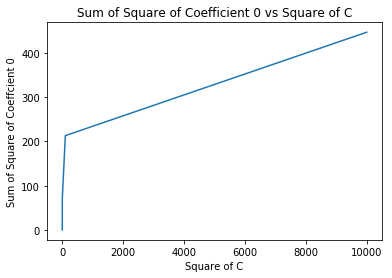

In [272]:
def P3c():
    
    #Unigram CountVectorizer
    vec = CountVectorizer()
    #create training vector
    X_train = vec.fit_transform(train_data)
    Y_train = train_labels
    #part 3.c
    model_num = 0
    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    #C_values = [0.001]
    X_plot = []
    Y_plot = []
    
    news_group0 = newsgroups_train.target_names[0]
    news_group1 = newsgroups_train.target_names[1]
    news_group2 = newsgroups_train.target_names[2]
    news_group3 = newsgroups_train.target_names[3]
    
    row_list = []
    
    for C_val in C_values:
        model_lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500, C = C_val)
        model_lr.fit(X_train, Y_train)
        #print ('C:', C_val, 'Sum of squares:', np.sum(np.square(model_lr.coef_), axis=1))
        
        Coeff_Square = np.sum(np.square(model_lr.coef_), axis=1)
        
        row_list.append({'C' : C_val, news_group0 : Coeff_Square[0], news_group1 : Coeff_Square[1],
                         news_group2 : Coeff_Square[2], news_group3 : Coeff_Square[3]})
        
        X_plot.append(C_val*C_val)
        Y_plot.append(np.sum(np.square(model_lr.coef_), axis=1)[0])
        
    df = pd.DataFrame(row_list)
    print ("-"*80)
    print ("Sum of Squares of Coefficients vs C")
    print ("-"*80)
    print (df)
    print ("-"*80)
    print ("")
    
    print ("-"*80)
    print ("Plotting Sum of Square of Coefficient vs Square of C for the newsgroup 0")
    print ("-"*80)
    
    plt.title("Sum of Square of Coefficient 0 vs Square of C")
    plt.ylabel("Sum of Square of Coeffcient 0")
    plt.xlabel("Square of C")
    plt.plot(X_plot, Y_plot)
        
P3c()

ANSWER: The Sum of Coefficients for each category is pretty much linear with Square of Coefficient for larger C values

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [273]:
def P4(grams = 1, preproc = 0):
    
    if (grams == 1) : 
        #Unigram CountVectorizer
        print ("-" * 80)
        print ("Using Unigram vectorizer")
        print ("-" * 80)
        vec = CountVectorizer()
    else :
        #Bigram
        print ("-" * 80)
        print ("Using Bigram vectorizer")
        print ("-" * 80)
        vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b', min_df=1)
    
    #Training vectors
    X_train = vec.fit_transform(train_data)
    Y_train = train_labels
    
    #Logistic Regression with C = 0.1
    model_lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500, C = 0.1)
    model_lr.fit(X_train, Y_train)

    #Create table using rows of hashes
    rows_list=[]
    
    #Get model_lr.coef_ and look at the top 5 values for each row
    for i in range (np.shape(model_lr.coef_)[0]):
        #print (newsgroups_train.target_names[i])
        test = model_lr.coef_[i,:]
        
        #print (test[0:4])
        temp = np.argpartition(-test, 5)
        result_args = temp[:5]

        temp = np.partition(-test, 5)
        result = -temp[:5]
    
        j = 0
        
        for elem in result_args.tolist() :
        
            ng = newsgroups_train.target_names[i]
            fn = vec.get_feature_names()[elem]
            pr = result[j]
            
            #print ("DF inputs", ng, fn, pr)
            
            rows_list.append({'Newsgroup':ng, 'Feature Name': fn, 'Probability': pr })
            j = j+1
            
            
    df = pd.DataFrame(rows_list)        
    df = df.reindex(columns = ['Newsgroup', 'Feature Name', 'Probability'])
    print (df)
    print ("-" * 80)
    print ("\n")
        
    
P4(grams = 1)
P4(grams = 2)

--------------------------------------------------------------------------------
Using Unigram vectorizer
--------------------------------------------------------------------------------
             Newsgroup Feature Name  Probability
0          alt.atheism     religion     0.406966
1          alt.atheism      atheism     0.378785
2          alt.atheism     atheists     0.352623
3          alt.atheism        bobby     0.338729
4          alt.atheism        islam     0.288105
5        comp.graphics        image     0.510989
6        comp.graphics         file     0.500007
7        comp.graphics           3d     0.420512
8        comp.graphics        files     0.393507
9        comp.graphics     graphics     0.766581
10           sci.space        space     0.998264
11           sci.space         nasa     0.440034
12           sci.space        orbit     0.452932
13           sci.space       launch     0.352130
14           sci.space   spacecraft     0.302788
15  talk.religion.misc       

ANSWER: The unigram vectorizer seems to be doing a good job of identifying the key features. There are some very relevant features (ex: christians for talk.religion.misc), but at the same time, a couple of irrelevant ones (ex: bobby for alt.atheism).
The bigram vectorizer seems to be doing a very pooor job in all the cases, except for sci.space. Most of the bigrams like "i see" and "cheers kent" seem to be way to generic or irrelevant. It seems that the unigram vectorizer is a better choice here.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [274]:
#def empty_preprocessor(s):
#    return s

def better_preprocessor(s):
    
    
    
    #remove commonly used english words
    #s = re.sub('\bthe\b', '', s, flags=re.IGNORECASE)
    #s = re.sub('\band\b', '', s, flags=re.IGNORECASE)
    #s = re.sub('\bit\b', '', s, flags=re.IGNORECASE)
    #s = re.sub('\bi\b','',s, flags=re.IGNORECASE)
    #s = re.sub('\bis\b','',s, flags=re.IGNORECASE)
    #s = re.sub('\bnot\b','',s, flags=re.IGNORECASE)
    #s = re.sub('\bwas\b','',s, flags=re.IGNORECASE)
    #s = re.sub('\bto\b','',s, flags=re.IGNORECASE)
    
    #Let's first remove digits only since they don't make sense
    s = re.sub('\d+',"digittoken",s)
    
    #remove 2 or more underscores
    s = re.sub('__+', " ", s)
    
    #remove underscores that are at the beginning of a word
    s = re.sub('_',' ',s)
    
    #replace n't with not
    s = re.sub('n\'t',' not',s)
    
    #remove greetings
    s = re.sub('\bhi\b',"",s,flags= re.IGNORECASE)
    s = re.sub('\bthanks\b',"",s,flags= re.IGNORECASE)
    s = re.sub('\bcheers\b',"",s,flags= re.IGNORECASE)
    s = re.sub('^hi\s+',"",s,flags= re.IGNORECASE)
    s = re.sub('^thanks\s+',"",s,flags= re.IGNORECASE)
    s = re.sub('^cheers\s+',"",s,flags= re.IGNORECASE)
    
    #remove names??
    s = re.sub('bobby','',s, flags = re.IGNORECASE)
    s = re.sub('kent','',s, flags = re.IGNORECASE)
    
    #ignore case
    s = s.lower()
    
    regex_pattern = re.compile(r'\s\w\w\s')
    #regex_pattern1 = re.compile(r'\d+')
    s = regex_pattern.sub(r' ', s)
    
    #Truncate long strings
    #s = re.sub(r'^(.{20}).*$', '\g<1>', s)
    
    return s

def P5(preproc = 1, debug = 0):
    
    if (preproc == 1) : 
        train_data_preproc = []
        dev_data_preproc = []
        
        print ("-"*80)
        print ("Turning on pre-processor")
        print ("-"*80)
        for i in range (len(train_data)) :
            train_data_preproc.append(better_preprocessor(train_data[i]))
       
        vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=1, 
                                   preprocessor = better_preprocessor)
        #vectorizer = CountVectorizer(preprocessor=better_preprocessor)
        X_train = vectorizer.fit_transform(train_data)
        
        print("Number of features:", len(vectorizer.get_feature_names()))
        
        for i in range (len(dev_data)) :
            dev_data_preproc.append(better_preprocessor(dev_data[i]))
            
        X_dev = vectorizer.transform(dev_data_preproc)
        
    else:
        print ("-"*80)
        print ("No preprocessing")
        print ("-"*80)
        
        #Let's look at the baseline vectorizer and see what can be improved
        vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', min_df=1)
        
        X_train = vectorizer.fit_transform(train_data)
        X_dev = vectorizer.transform(dev_data)
        print("Number of features:", len(vectorizer.get_feature_names()))
    
    #First 200 feature names
    if (debug == 1) :
        for i in range (50):
            print ("i:", i, "Name:", vectorizer.get_feature_names()[i+4000])
    else: 
    
        Y_train = train_labels
        Y_dev = dev_labels
        
        C_val = [0.01, 0.1, 1, 10, 100, 1000]
        
        rows_list = []
    
        for C in C_val :
            #Logistic Regression with C = 100
            model_lr = LogisticRegression(solver='lbfgs', multi_class='auto', C = C, max_iter=500, tol=0.01)
            model_lr.fit(X_train, Y_train)
    
            #predicted_labels = model_lr.predict(X_dev)
            model_score = model_lr.score(X_dev, Y_dev)
            rows_list.append({'C Value': C, 'Model Score': model_score })
    
    df = pd.DataFrame(rows_list)
    print (df)
    print ("-"*80)
    print ("\n")
    
P5(preproc = 0, debug = 0)
P5(preproc = 1, debug = 0)

--------------------------------------------------------------------------------
No preprocessing
--------------------------------------------------------------------------------
Number of features: 26919
   C Value  Model Score
0     0.01     0.670118
1     0.10     0.690828
2     1.00     0.681953
3    10.00     0.692308
4   100.00     0.674556
5  1000.00     0.677515
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Turning on pre-processor
--------------------------------------------------------------------------------
Number of features: 24302
   C Value  Model Score
0     0.01     0.668639
1     0.10     0.710059
2     1.00     0.704142
3    10.00     0.693787
4   100.00     0.687870
5  1000.00     0.687870
--------------------------------------------------------------------------------




ANSWER: The pre-processor improved the accuracy from 69.08% to 71.00%

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

--------------------------------------------------------------------------------
Trying out Grid Search on C values for Logistic Regression for L2 model
--------------------------------------------------------------------------------
[0.62831858 0.76548673 0.80088496 0.78416912 0.7826942  0.77187807
 0.76647001]
The best alpha value for Logistic Regression with l2 penalty {'C': 0.1}
The best Model score for Logistic Regression with l2 penalty 0.8008849557522124
L2 Model Score:  0.7307692307692307 Number of zero coefficients: 75056
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Training with L1 model for C =  0.01
--------------------------------------------------------------------------------
C value:  0.01 Model Score:  0.46005917159763315 Number of zero coefficients: 106294
Using L1 optimized features to train L2 model using GridSearchCV
The best alpha value for Logist

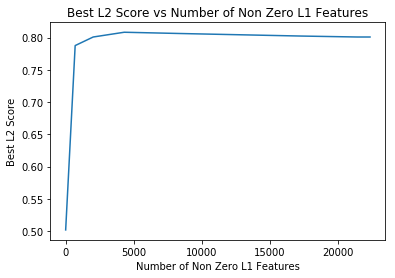

In [283]:
def P6():
    
    # Initialize seed
    np.random.seed(50)
    
    vec = CountVectorizer(stop_words='english')
    X_train = vec.fit_transform(train_data)
    Y_train = train_labels
    
    X_dev = vec.transform(dev_data)
    Y_dev = dev_labels
    
    #L2 model
    model_lr_l2 = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter=500, tol = 0.01, penalty = 'l2')
    C_values = {'C': [0.001, 0.01, 0.1, 1, 2, 5, 10]}
    clf_lr_l2 = GridSearchCV(model_lr_l2, C_values, cv =5)
    clf_lr_l2.fit(X_train, Y_train)
    print ("-"*80)
    print ("Trying out Grid Search on C values for Logistic Regression for L2 model")
    print ("-"*80)
    print(clf_lr_l2.cv_results_['mean_test_score'])
    print("The best alpha value for Logistic Regression with l2 penalty", clf_lr_l2.best_params_)
    print("The best Model score for Logistic Regression with l2 penalty", clf_lr_l2.best_score_)
    
    
    #Best C value is 0.1
    model_lr_l2 = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter=500, tol = 0.01, penalty = 'l2', C = 0.1)
    model_lr_l2.fit (X_train, Y_train)
    zero_coef_sum_l2 = np.sum(model_lr_l2.coef_ < 0.0000000001)
    model_l2_score = model_lr_l2.score(X_dev, Y_dev)
    print ("L2 Model Score: ", model_l2_score, "Number of zero coefficients:", zero_coef_sum_l2)
    print ("-"*80)
    print ("\n")
    
    #L1 model
    l2_opt_list = []
    
    #for C in [0.01, 0.1] :
    for C in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10] : 
        print("-"*80)
        print ("Training with L1 model for C = ", C)
        print("-"*80)
        
        model_lr_l1 = LogisticRegression(solver = 'saga', multi_class='auto', max_iter=500, tol = 0.01, penalty = 'l1', C = C)
        
        #Fit the model with training data
        model_lr_l1.fit(X_train, Y_train)
        
        pred_l1_dev = model_lr_l1.predict(X_dev)
        model_l1_score = model_lr_l1.score(X_dev, Y_dev)
        
        zero_coef_sum_l1 = np.sum(model_lr_l1.coef_ < 0.0000000001)
        
        print ("C value: ", C, "Model Score: ", model_l1_score, "Number of zero coefficients:", zero_coef_sum_l1)
        
        #Use only the L1 features that have at least one non-zero coefficient value
        non_zero_coef_sum = model_lr_l1.coef_ > 0.0000000001
        non_zero_feature_vec = np.any (non_zero_coef_sum, axis = 0)
        num_non_zero_l1_features = np.sum(non_zero_feature_vec)
    
        l1_opt_vocab = []
        for i in range(len(vec.get_feature_names())) :
            if (non_zero_feature_vec[i]) :
                l1_opt_vocab.append(vec.get_feature_names()[i])
        
        #now try out L2 model optimization with the limited vocabulary
        opt_vec = CountVectorizer(vocabulary=l1_opt_vocab, stop_words='english')
        model_lr_l2_opt = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter=500, tol = 0.01, penalty = 'l2')
        X_train_opt = opt_vec.fit_transform(train_data)
        
        clf_lr_l2_opt = GridSearchCV(model_lr_l2_opt, C_values, cv =5)
        clf_lr_l2_opt.fit(X_train_opt, Y_train)
        print("Using L1 optimized features to train L2 model using GridSearchCV")
        print("The best alpha value for Logistic Regression with l2 for ", clf_lr_l2_opt.best_params_)
        print("The best model score for Logistic Regression with l2", clf_lr_l2_opt.best_score_)
        print("-"*80)
        print("\n")
        
        l2_opt_list.append({ 'C Value for L1' : C,
                             'Num non zero L1 features': num_non_zero_l1_features, 
                             'Best L2 C': clf_lr_l2_opt.best_params_,
                             'Best L2 Score' : clf_lr_l2_opt.best_score_})
        
    
    print ("-"*80)
    print ("Best L2 Model Score vs Number of L1 Optimized Features")
    print ("-"*80)
    print ("\n")
    
    df_l2 = pd.DataFrame(l2_opt_list)
    df_l2 = df_l2.reindex(columns = ['C Value for L1', 'Num non zero L1 features','Best L2 Score', 'Best L2 C'])
    print (df_l2)
    plt.plot(df_l2['Num non zero L1 features'], df_l2['Best L2 Score'])
    plt.xlabel("Number of Non Zero L1 Features")
    plt.ylabel("Best L2 Score")
    plt.title("Best L2 Score vs Number of Non Zero L1 Features")
P6()


ANSWER: The best results were obtained for around 4312 non-zero features compared to a total of over 27,000 features. 

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [281]:
def P7(fix_weight = 0, bigram = False):
    
    if (bigram == True):
        count_vec = CountVectorizer(stop_words = 'english', ngram_range=(1, 2))
        tfidf_vec = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 2))
    else:
        count_vec = CountVectorizer(stop_words = 'english')
        tfidf_vec = TfidfVectorizer(stop_words = 'english')
    
    #create training vector for tfidf and count vectorizers
    X_train_count = count_vec.fit_transform(train_data)
    X_train_tfidf = tfidf_vec.fit_transform(train_data)
    
    Y_train_count = train_labels
    Y_train_tfidf = train_labels
    
    #Use logistic regression
    model_lr_l2 = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter=500, tol = 0.01, penalty = 'l2')
    
    #Run a Grid Search for each and figure out best values
    C_values = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    clf_lr_l2 = GridSearchCV(model_lr_l2, C_values, cv =5)
    
    #First try out with count vec
    clf_lr_l2.fit(X_train_count, Y_train_count)
    print("The best alpha value for Logistic Regression with CountVectorizer is ", clf_lr_l2.best_params_)
    print("The best f1 score for Logistic Regression with CountVectorizer is", clf_lr_l2.best_score_)
    
    #Repeat with Tfidf and see the difference
    clf_lr_l2.fit(X_train_tfidf, Y_train_tfidf)
    print("The best alpha value for Logistic Regression with TfidfVectorizer is ", clf_lr_l2.best_params_)
    print("The best f1 score for Logistic Regression with TfidfVectorizer is", clf_lr_l2.best_score_)
    
    #Fix weights of training set
    if (fix_weight == 1):
        #One way of fixing the problem is to increase the weight of important words like "mormon" and "jesus" 
        #Let's try this out
        for imp_words in ['mormon', 'jesus', 'devil', 'atheist', 'christian', 
                          'muslim', 'religion', 'belief', 'believe']:
            position = tfidf_vec.vocabulary_[imp_words]
            X_train_tfidf[:,position] = 10* X_train_tfidf[:,position] 
            
    #Using C = 100 to find out the ratio where predictions were correct but ratios we lowest
    model_lr_l2 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500, C = 100, tol = 0.01)
    model_lr_l2.fit(X_train_tfidf, Y_train_tfidf)
    
    X_dev_tfidf = tfidf_vec.transform(dev_data)
    
    #Fix weights of dev set
    if (fix_weight == 1):
        #One way of fixing the problem is to increase the weight of important words like "mormon" and "jesus" 
        #Let's try this out
        for imp_words in ['mormon', 'jesus', 'devil', 'atheist', 'christian', 
                          'muslim', 'religion', 'belief', 'believe']:
            position = tfidf_vec.vocabulary_[imp_words]
            X_dev_tfidf[:,position] = 10* X_dev_tfidf[:,position]
    
    predicted_labels = model_lr_l2.predict(X_dev_tfidf)
    predicted_prob = model_lr_l2.predict_proba(X_dev_tfidf)
    
    pred_probs_max = np.max(predicted_prob, axis = 1)
    
    corr_prob = np.empty_like(pred_probs_max)
    
    for i in range (np.shape(predicted_prob)[0]):
        corr_probability = predicted_prob[i][dev_labels[i]]
        corr_prob[i] = corr_probability
        
    prob_ratio = pred_probs_max/corr_prob
    
    #Print the max 5 args
    print ("-"*80)
    print ("Largest 5 ratios", (-np.sort(-prob_ratio))[0:5])
    prob_ratio_max_index = (np.argsort(-prob_ratio)[0:5])
    print ("Indices with largest 5 ratios", prob_ratio_max_index )
    print ("-"*80)
    
    #Print out the probabilities of the highest 3 violators
    for i in (prob_ratio_max_index):
        print ("-"*80)
        print ("Top 5 violator belongs to class", newsgroups_train.target_names[dev_labels[i]])
        print ("But wrongly predicted as belonging to", newsgroups_train.target_names[predicted_labels[i]])
        print ("-"*80)
        print (dev_data[i])
        print ("-"*80)
        print ("\n")
    
P7(fix_weight = 0, bigram = False)
    

The best alpha value for Logistic Regression with CountVectorizer is  {'C': 0.1}
The best f1 score for Logistic Regression with CountVectorizer is 0.8008849557522124
The best alpha value for Logistic Regression with TfidfVectorizer is  {'C': 10}
The best f1 score for Logistic Regression with TfidfVectorizer is 0.8377581120943953
--------------------------------------------------------------------------------
Largest 5 ratios [1180.95516347  282.44990514  123.37082009   89.89050669   80.71781859]
Indices with largest 5 ratios [215 665 471 181 209]
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Top 5 violator belongs to class talk.religion.misc
But wrongly predicted as belonging to comp.graphics
--------------------------------------------------------------------------------
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title:

ANSWER: 
In the above analysis (without any experiments on how to resolve the problem), what I found was that there are some topics flagged as comp.graphics even though they belong to alt.atheism or talk.religion.misc. There is also a confusion between alt.atheism and talk.religion.misc. The latter one is very dificult to classify because intuitively some of the atheism topics will contain details on religion and vice-versa. In fact, they are so close that it is not even possible for humans to classify the content as one or the other.

An experiment that I wanted to try out was to increase the weight of certain important words like "Mormon", "Jesus" and so on so that I can assign 10x more weight in the tfidf computation. By doing this, it is possible to influence the classifier to make better decisions.

I tried this out the code in the "fix_weight == 1" section below. Here I increased the weights for the "important words" and found that I can eliminate the misclassification of documents as comp.graphics. However, I found that pretty much all the misclassification now is between alt.atheism and talk.religion.misc. I think classifying amongst these two topics is not very easy and requires a lot of sentiment analysis. 

Example: Even your Bible cannot agree on how things were created.  Why should we believe in it? This requires analyzing sentences and not words. The actual class is alt.atheism but is mispredicted as talk.religion.misc due to a lot of words like "bible", "lord" and so on. Perhaps we need to look for words like "contradicts", "cannot agree" and "not believe" and so on.

In [282]:
P7(fix_weight = 1, bigram = False)

The best alpha value for Logistic Regression with CountVectorizer is  {'C': 0.1}
The best f1 score for Logistic Regression with CountVectorizer is 0.8008849557522124
The best alpha value for Logistic Regression with TfidfVectorizer is  {'C': 10}
The best f1 score for Logistic Regression with TfidfVectorizer is 0.8377581120943953
--------------------------------------------------------------------------------
Largest 5 ratios [1041.57034715  105.41674232   88.75414785   80.06978688   76.60747463]
Indices with largest 5 ratios [287 181 215 471 203]
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Top 5 violator belongs to class alt.atheism
But wrongly predicted as belonging to talk.religion.misc
--------------------------------------------------------------------------------
With the Southern Baptist Convention convening this June to consider
the charges that Freemasonry is in

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.